In [2]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data = arff.loadarff('./data/database.arff')
database = pd.DataFrame(data[0])

database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 81 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MS_SubClass         2930 non-null   object 
 1   MS_Zoning           2930 non-null   object 
 2   Lot_Frontage        2930 non-null   float64
 3   Lot_Area            2930 non-null   float64
 4   Street              2930 non-null   object 
 5   Alley               2930 non-null   object 
 6   Lot_Shape           2930 non-null   object 
 7   Land_Contour        2930 non-null   object 
 8   Utilities           2930 non-null   object 
 9   Lot_Config          2930 non-null   object 
 10  Land_Slope          2930 non-null   object 
 11  Neighborhood        2930 non-null   object 
 12  Condition_1         2930 non-null   object 
 13  Condition_2         2930 non-null   object 
 14  Bldg_Type           2930 non-null   object 
 15  House_Style         2930 non-null   object 
 16  Overal

In [3]:
#sostituisco i bites in stringa
database[database.select_dtypes('object').columns] = database.select_dtypes('object').stack().str.decode('utf-8').unstack()


In [4]:
print(database.head())

                           MS_SubClass                 MS_Zoning  \
0  One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
1  One_Story_1946_and_Newer_All_Styles  Residential_High_Density   
2  One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
3  One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
4             Two_Story_1946_and_Newer   Residential_Low_Density   

   Lot_Frontage  Lot_Area Street            Alley           Lot_Shape  \
0         141.0   31770.0   Pave  No_Alley_Access  Slightly_Irregular   
1          80.0   11622.0   Pave  No_Alley_Access             Regular   
2          81.0   14267.0   Pave  No_Alley_Access  Slightly_Irregular   
3          93.0   11160.0   Pave  No_Alley_Access             Regular   
4          74.0   13830.0   Pave  No_Alley_Access  Slightly_Irregular   

  Land_Contour Utilities Lot_Config  ...            Fence Misc_Feature  \
0          Lvl    AllPub     Corner  ...         No_Fence         None   
1   

1) Notiamo la elevata presenza di valori non numerici ma stringa -> possibile risoluzione con OneHot-Encoding
2) Alcuni valori stringa sono riconducibili a valori come 0 e 1 poichè presentano o solo 2 valori (non numerici) oppure a piu valori raggruppabili per il scarso 

In [5]:
#Suddivido in train e test prima

from sklearn.model_selection import train_test_split
%matplotlib inline

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score

#divido tra train test, però non validation


# elimino le colonne non utili
X = database.drop(columns=['Sale_Price']) #droppo la colonna dei prezzi che devo predirre
#isolo y variabile target
y = database['Sale_Price']
# e la divido in train e test e validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)



## Nuove Feature

In [6]:
#età dall'ultimo rinnovo
X_train['Bldg_Year'] = X_train['Year_Remod_Add'] - X_train['Year_Sold']  #C'è anche la casa negativa cioè rinnovata nel 2001 e costruita nel 2002(?)
X_test['Bldg_Year'] = X_test['Year_Remod_Add'] - X_test['Year_Sold'] 

In [7]:
#numero bagni totali
X_train['Tot_Bath']=X_train['Half_Bath']+X_train['Full_Bath']+X_train['Bsmt_Half_Bath']+X_train['Bsmt_Full_Bath']
X_test['Tot_Bath']=X_test['Half_Bath']+X_test['Full_Bath']+X_test['Bsmt_Half_Bath']+X_test['Bsmt_Full_Bath']

In [8]:
#rapporto tra auto e garage
X_train['Garage_Perc']=X_train['Garage_Cars']/X_train['Garage_Area']
X_test['Garage_Perc']=X_test['Garage_Cars']/X_test['Garage_Area']

X_train['Garage_Perc']=X_train['Garage_Perc'].fillna(0)
X_test['Garage_Perc']=X_test['Garage_Perc'].fillna(0)


In [9]:
#somma piani
X_train["All_Flr_SF"] = X_train["First_Flr_SF"] + X_train["Second_Flr_SF"]
X_test["All_Flr_SF"] = X_test["First_Flr_SF"] + X_test["Second_Flr_SF"]

### Cluster  -> classificazione delle zone 


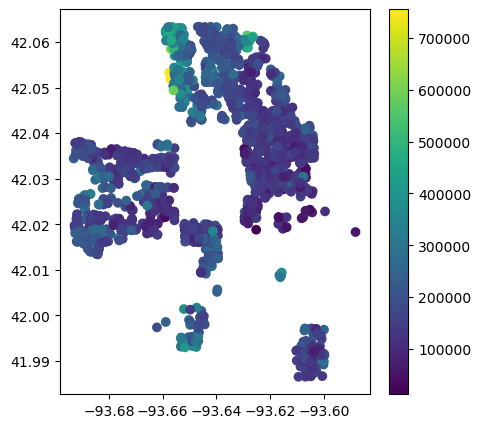

In [10]:
plt.subplots(figsize=(5,5))
plt.scatter(X_train['Longitude'],X_train['Latitude'], c=y_train, cmap='viridis')
plt.colorbar()
plt.show()


In [11]:
zone_train = pd.DataFrame(data={"Latitude":X_train["Latitude"],"Longitude":X_train["Longitude"]})
zone_test = pd.DataFrame(data={"Latitude":X_test["Latitude"],"Longitude":X_test["Longitude"]})
X_train.shape

(2051, 84)

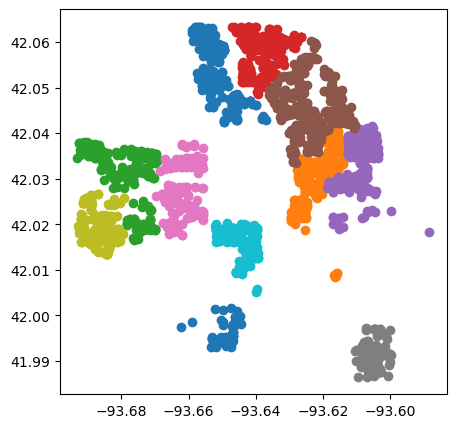

In [12]:
# agglomerative clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot


AGcluster = AgglomerativeClustering(n_clusters=11)
yhat_AG = AGcluster.fit_predict(zone_train)
clusters_AG = unique(yhat_AG)

plt.subplots(figsize=(5,5))

for cluster in clusters_AG:
    row_ix = where(yhat_AG == cluster)
    pyplot.scatter(zone_train.Longitude.iloc[row_ix], zone_train.Latitude.iloc[row_ix])
# show the plot
pyplot.show()

22


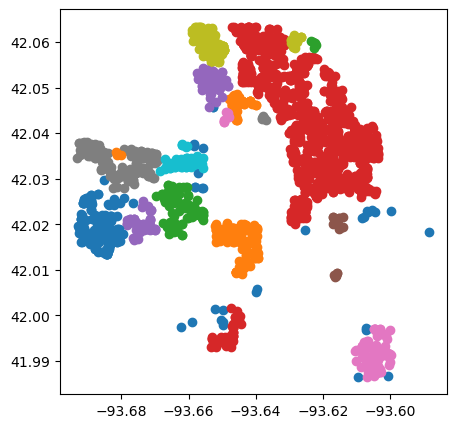

In [13]:
# dbscan clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from matplotlib import pyplot

model_DB = DBSCAN(eps=0.002)

print(len(unique(model_DB.fit(zone_train).labels_)))
yhat_DB = model_DB.fit_predict(zone_train)

clusters = unique(yhat_DB)

plt.subplots(figsize=(5,5))

for cluster in clusters:
    row_ix = where(yhat_DB == cluster)
    pyplot.scatter(zone_train.Longitude.iloc[row_ix], zone_train.Latitude.iloc[row_ix])

pyplot.show()

c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


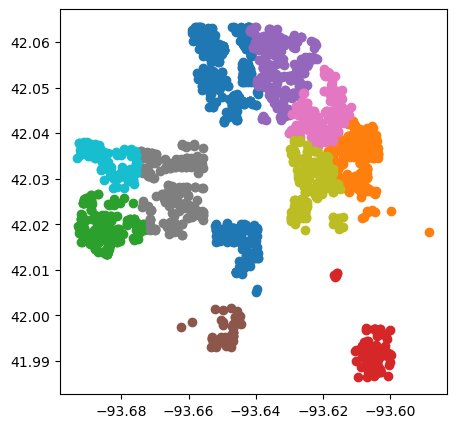

In [14]:
# gaussian mixture clustering
from numpy import unique
from numpy import where
import numpy
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot

model_GM = GaussianMixture(n_components=11,covariance_type='tied',random_state=25)

s= model_GM.fit(zone_train)
(yhat_GM) = model_GM.predict(zone_train)
clusters = unique(yhat_GM)
plt.subplots(figsize=(5,5))

for cluster in clusters:
    row_ix = where(yhat_GM == cluster)
    pyplot.scatter(zone_train.Longitude.iloc[row_ix], zone_train.Latitude.iloc[row_ix])
    
zone_train_cluster = yhat_GM
pyplot.show()


### silhouette score samples

#### KMeans siluette

c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.48036412442305354
For n_clusters = 7 The average silhouette_score is : 0.47218442000341865


c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


For n_clusters = 8 The average silhouette_score is : 0.46245616569865283
For n_clusters = 9 The average silhouette_score is : 0.4452904423977673


c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


For n_clusters = 10 The average silhouette_score is : 0.44526349587413383
For n_clusters = 11 The average silhouette_score is : 0.4587773628917539


c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


For n_clusters = 12 The average silhouette_score is : 0.4635988956571452
For n_clusters = 13 The average silhouette_score is : 0.4468945679342876


c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


For n_clusters = 14 The average silhouette_score is : 0.46849307402800233
Silhouette Coefficient: 0.450


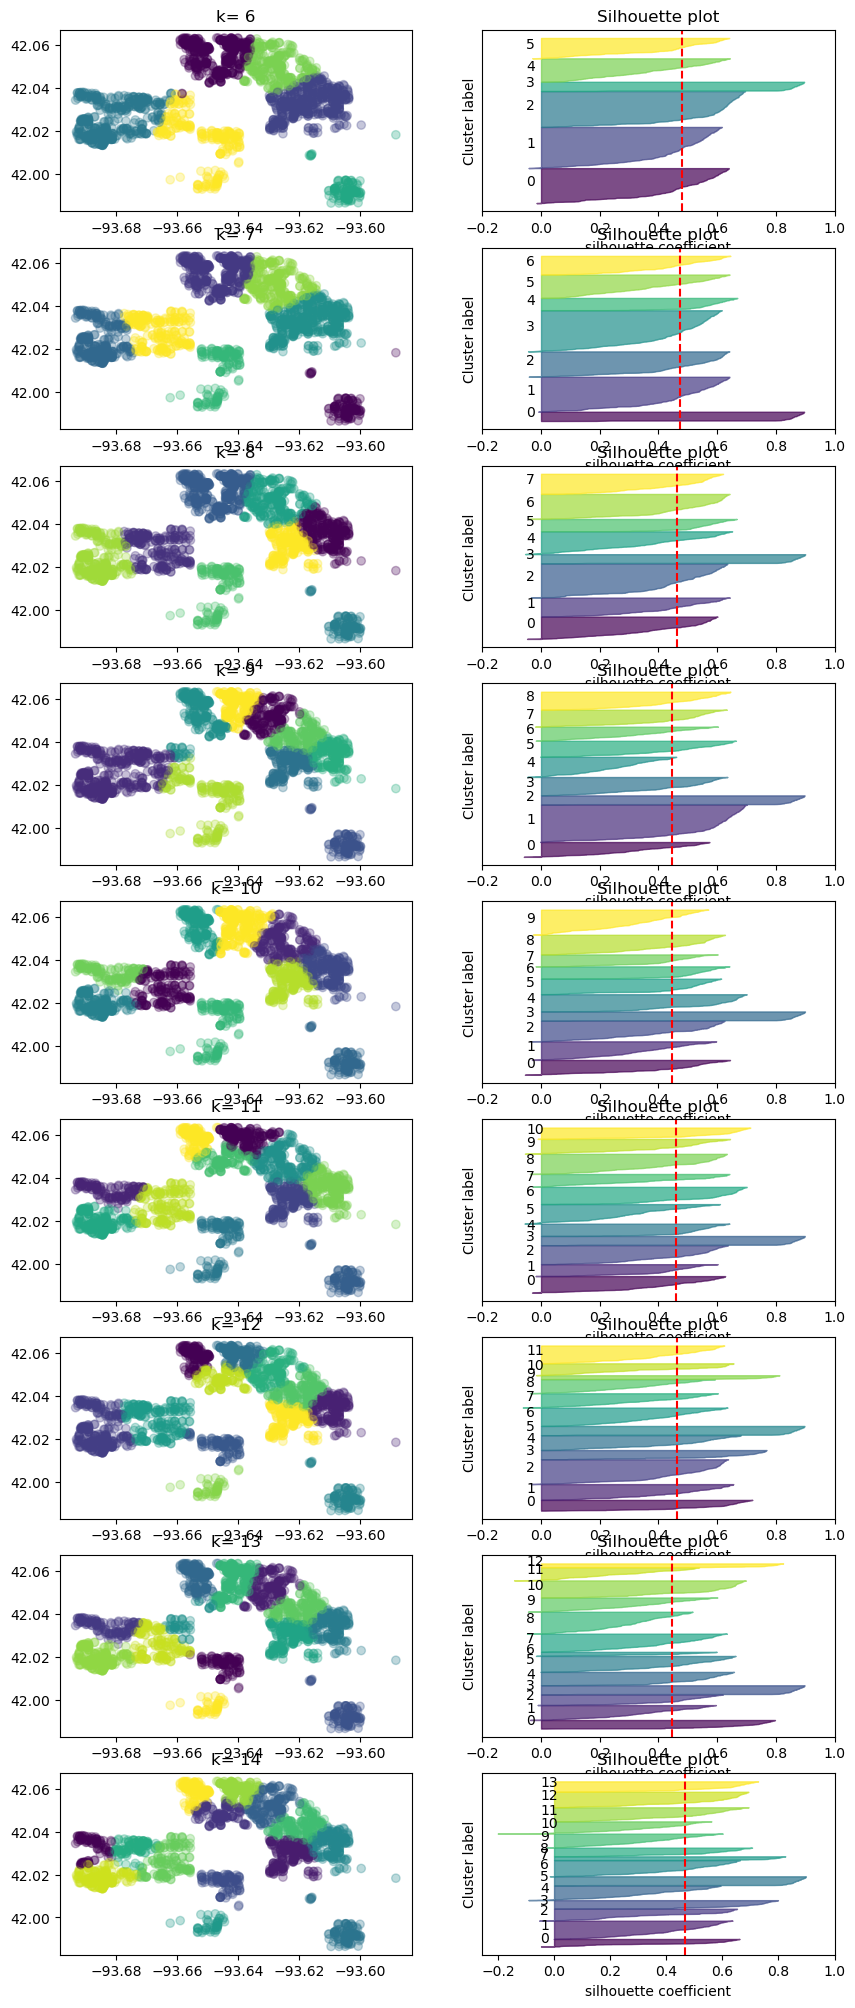

In [15]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


n_clusters = range(6,15)
fig, axs = plt.subplots(nrows=len(n_clusters), ncols=2)
fig.set_size_inches(10, 25)

for i, n_c in enumerate(n_clusters):

    # K-Means
    k_means = KMeans(n_clusters=n_c, n_init=1)
    k_means.fit(zone_train)
    labels= k_means.labels_
    
    # plot output of k-means
    axs[i,0].scatter(zone_train.Longitude, zone_train.Latitude, c=k_means.labels_, alpha=0.3)
    c = k_means.cluster_centers_
    
    axs[i,0].set_title("k= "+str(n_c))
    
    # silhouette
    silhouette_avg = silhouette_score(zone_train, k_means.labels_)
    print("For n_clusters =", n_c,
          "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(zone_train, k_means.labels_)

    y_lower = 0
    for j in range(n_c):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[k_means.labels_ == j]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.viridis(float(j) / (n_c-1))
        axs[i,1].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        axs[i,1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper

    axs[i,1].set_title("Silhouette plot")
    axs[i,1].set_xlabel("silhouette coefficient")
    axs[i,1].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    axs[i,1].axvline(x=silhouette_avg, color="red", linestyle="--")

    axs[i,1].set_yticks([])  # Clear the yaxis labels / ticks
    axs[i,1].set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
X = StandardScaler().fit_transform(zone_train)
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")


#### Gaussian Mixture silhouette


c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.4752012320986235


c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


For n_clusters = 7 The average silhouette_score is : 0.4116389384216595
For n_clusters = 8 The average silhouette_score is : 0.45282720469258203
For n_clusters = 9 The average silhouette_score is : 0.4393567259179924


c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


For n_clusters = 10 The average silhouette_score is : 0.4466738033758871


c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


For n_clusters = 11 The average silhouette_score is : 0.45003219237878755
For n_clusters = 12 The average silhouette_score is : 0.45309737584430587


c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
c:\Users\alessandro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


For n_clusters = 13 The average silhouette_score is : 0.4427284532413475
For n_clusters = 14 The average silhouette_score is : 0.4378401213619128
Silhouette Coefficient: 0.386


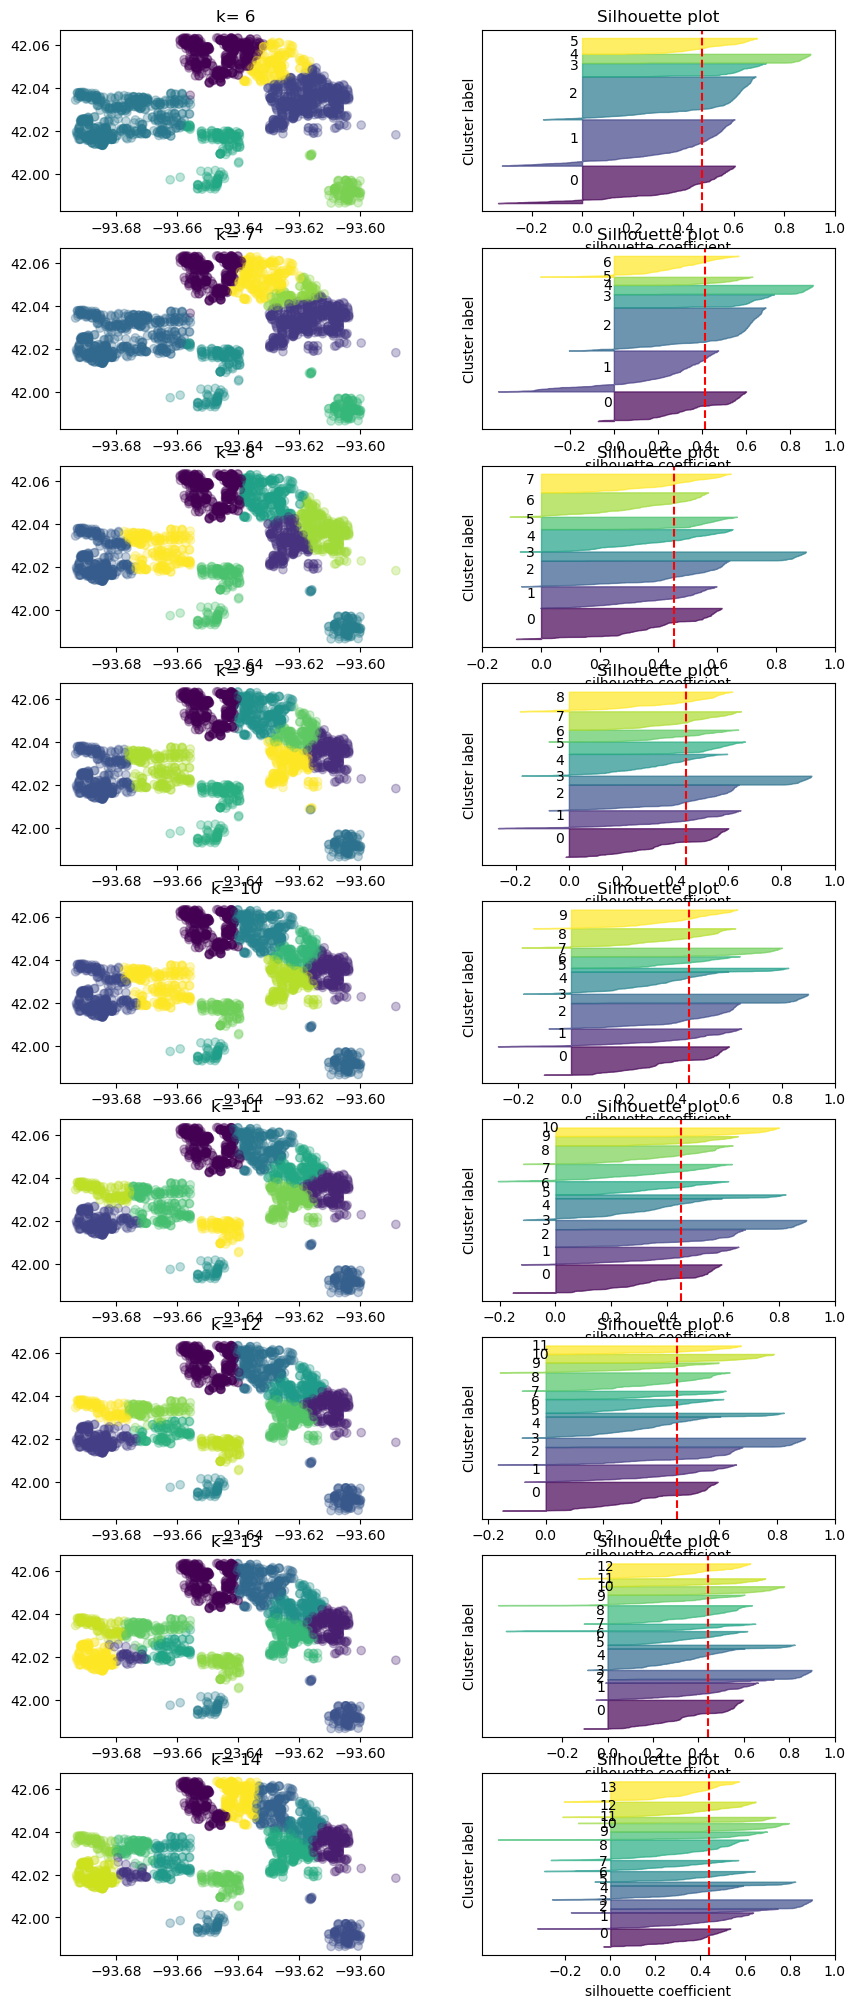

In [16]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

fig, axs = plt.subplots(nrows=len(n_clusters), ncols=2)
fig.set_size_inches(10, 25)

for i, n_c in enumerate(n_clusters):

    # -----------
    # K-Means
    model_GM = GaussianMixture(n_components=n_c, covariance_type='tied',random_state=25)
    model_GM.fit(zone_train)
    labels= model_GM.predict(zone_train)
    
    axs[i,0].scatter(zone_train.Longitude, zone_train.Latitude, c=labels, alpha=0.3)
    
    axs[i,0].set_title("k= "+str(n_c))
    
    # silhouette
    silhouette_avg = silhouette_score(zone_train, labels)
    print("For n_clusters =", n_c,
          "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(zone_train, labels)

    y_lower = 0
    for j in range(n_c):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == j]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.viridis(float(j) / (n_c-1))
        axs[i,1].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        axs[i,1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper

    axs[i,1].set_title("Silhouette plot")
    axs[i,1].set_xlabel("silhouette coefficient")
    axs[i,1].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    axs[i,1].axvline(x=silhouette_avg, color="red", linestyle="--")

    axs[i,1].set_yticks([])  # Clear the yaxis labels / ticks
    axs[i,1].set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
X = StandardScaler().fit_transform(zone_train)
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

For n_clusters = 6 The average silhouette_score is : 0.4616731394697791
For n_clusters = 7 The average silhouette_score is : 0.44155459701409644
For n_clusters = 8 The average silhouette_score is : 0.4411055814771631
For n_clusters = 9 The average silhouette_score is : 0.41442487157002905
For n_clusters = 10 The average silhouette_score is : 0.40255547764627486
For n_clusters = 11 The average silhouette_score is : 0.41388192759856113
For n_clusters = 12 The average silhouette_score is : 0.4223853028827566
For n_clusters = 13 The average silhouette_score is : 0.4298348104643021
For n_clusters = 14 The average silhouette_score is : 0.42601401090585694
Silhouette Coefficient: 0.406


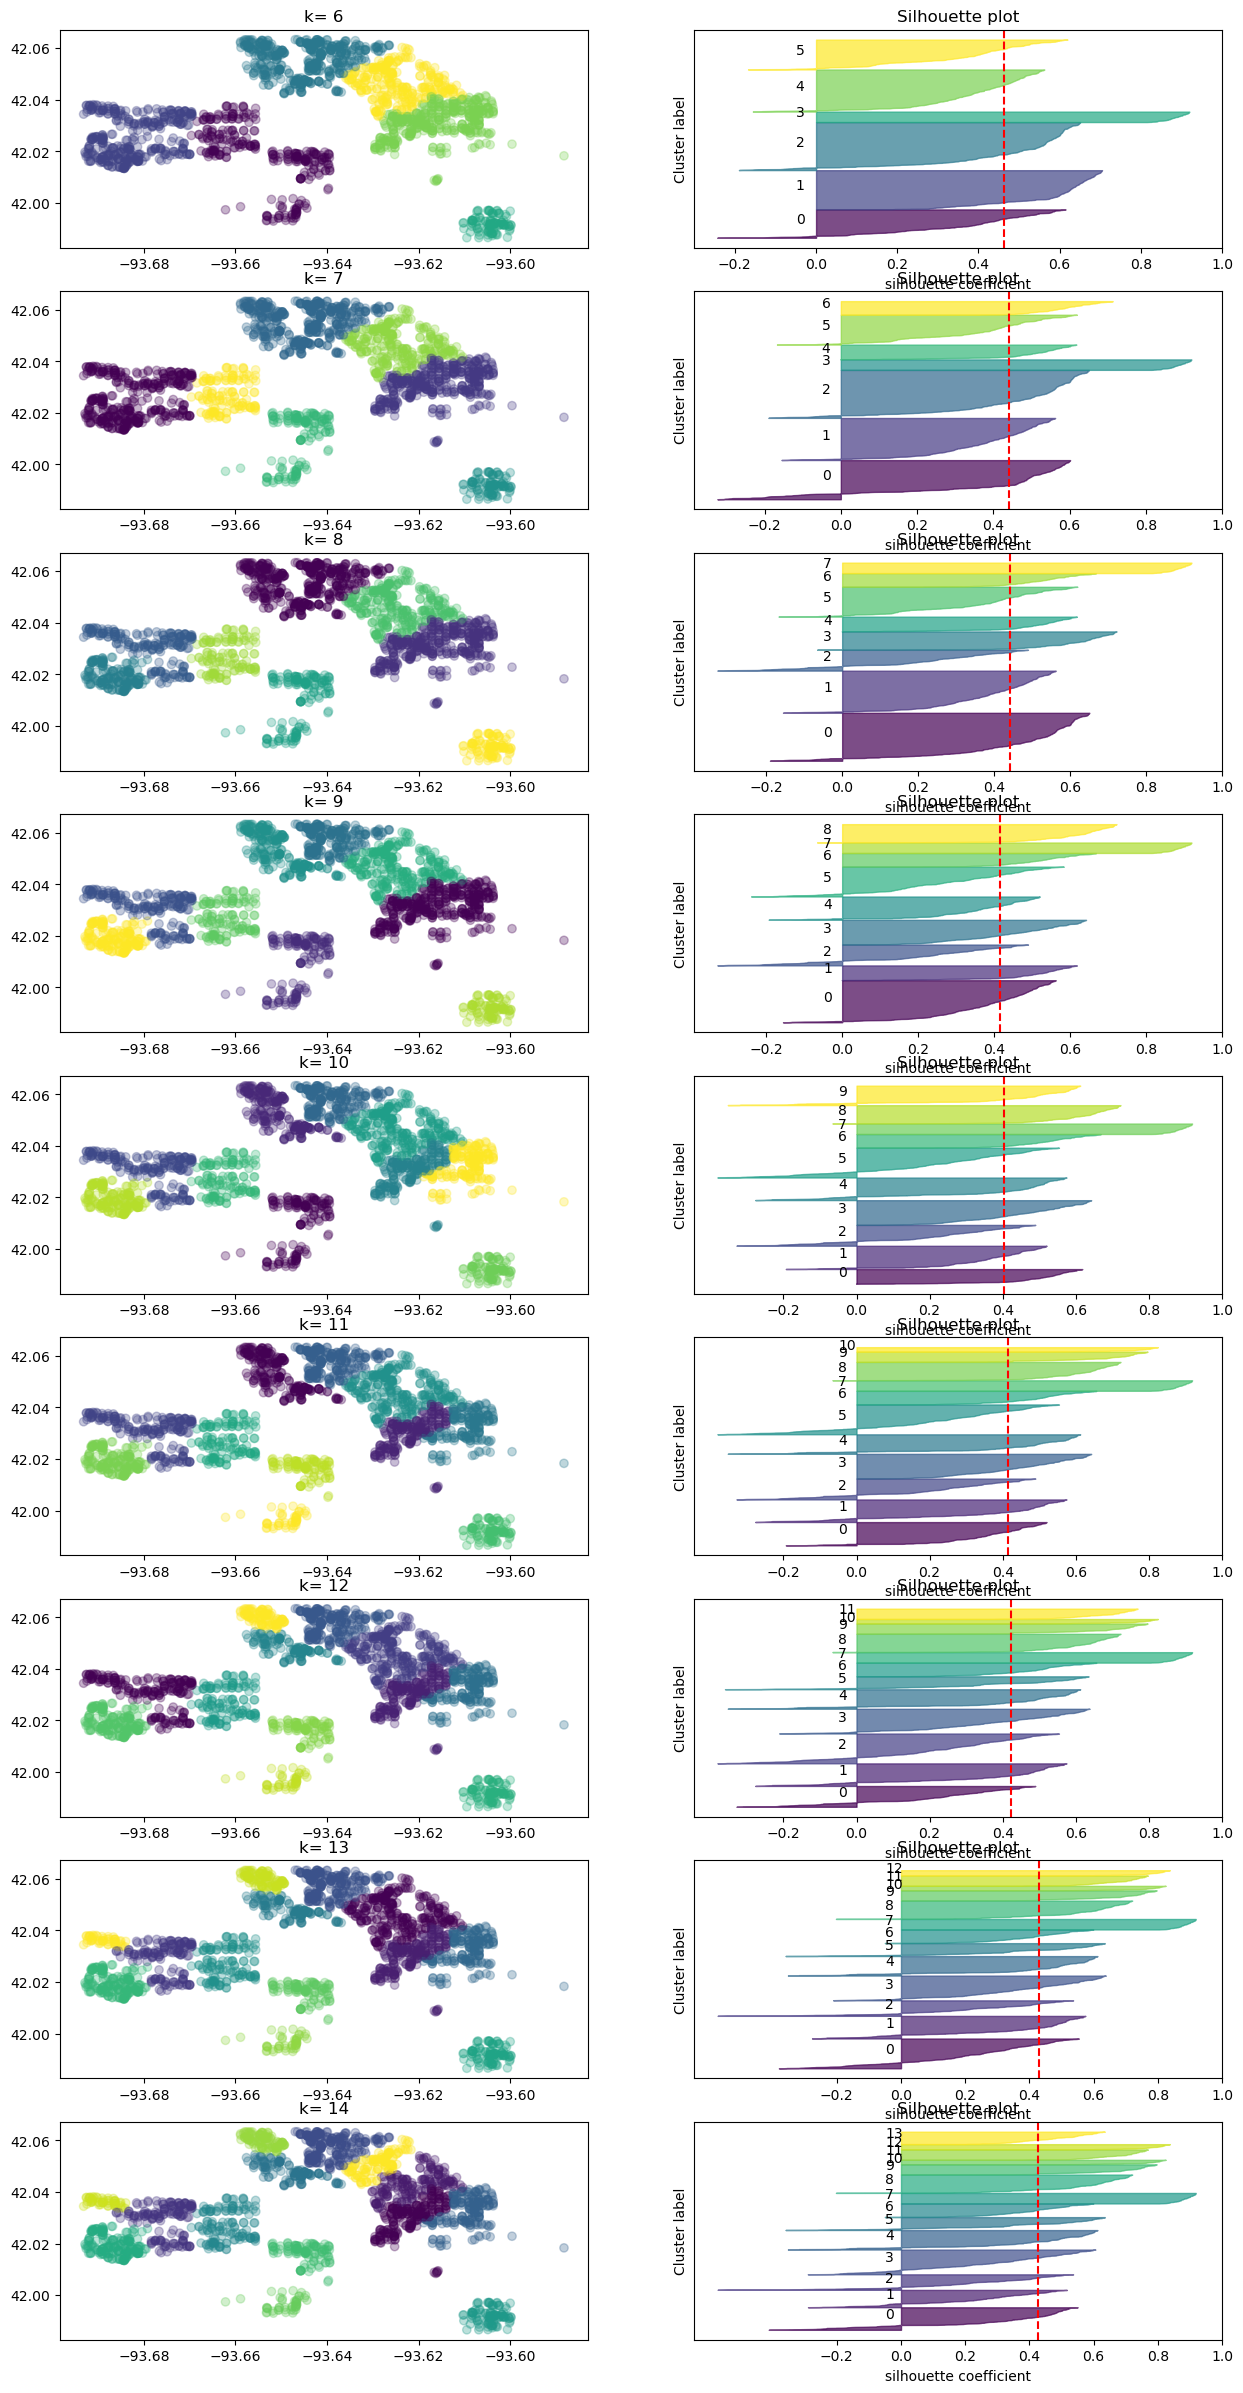

In [17]:
from sklearn import metrics
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

fig, axs = plt.subplots(nrows=len(n_clusters), ncols=2)
fig.set_size_inches(15, 30)

for i, n_c in enumerate(n_clusters):

    # -----------
    # K-Means
    model_GM = AgglomerativeClustering(n_clusters=n_c)
    model_GM.fit(zone_train)
    labels= model_GM.fit_predict(zone_train)
    
    axs[i,0].scatter(zone_train.Longitude, zone_train.Latitude, c=labels, alpha=0.3)
    
    axs[i,0].set_title("k= "+str(n_c))
    
    # silhouette
    silhouette_avg = silhouette_score(zone_train, labels)
    print("For n_clusters =", n_c,
          "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(zone_train, labels)

    y_lower = 0
    for j in range(n_c):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == j]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.viridis(float(j) / (n_c-1))
        axs[i,1].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        axs[i,1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper

    axs[i,1].set_title("Silhouette plot")
    axs[i,1].set_xlabel("silhouette coefficient")
    axs[i,1].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    axs[i,1].axvline(x=silhouette_avg, color="red", linestyle="--")

    axs[i,1].set_yticks([])  # Clear the yaxis labels / ticks
    axs[i,1].set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
X = StandardScaler().fit_transform(zone_train)
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

In [18]:
X_train['Zone'] = yhat_AG
test_labels = AGcluster.fit_predict(zone_test)
X_test['Zone'] = test_labels.astype(float)

<Axes: xlabel='Zone', ylabel='Sale_Price'>

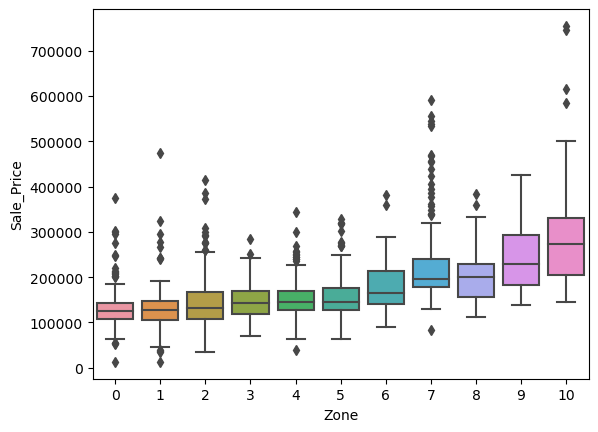

In [19]:
import seaborn as sns
concat= pd.concat([X_train, y_train],axis=1)
zone_sorted= concat.groupby(['Zone']).median(numeric_only=True).Sale_Price.sort_values(ascending=True).index
sort = dict(zip(zone_sorted, range(len(zone_sorted.to_list()))))
X_train = X_train.replace({'Zone': sort})
sns.boxplot(x='Zone', y='Sale_Price',data = pd.concat([X_train, y_train],axis=1))

### zone con mediana

In [20]:
zone_median= concat.groupby(['Zone']).median(numeric_only=True).Sale_Price
median = dict(zip(range(len(zone_median.to_list())),zone_median ))
X_train = X_train.replace({'Zone': median})
X_test = X_test.replace({'Zone': median})


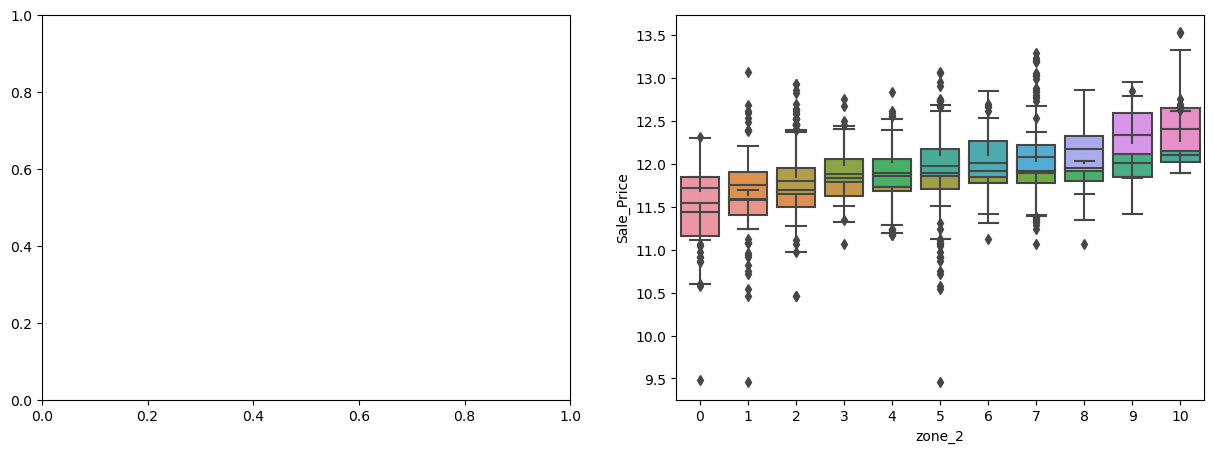

In [40]:
zone_clusters= {model_DB: yhat_DB, model_GM:yhat_GM}
clu=1
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for cluster,yhat in zone_clusters.items():
    
    X_train[f'zone_{clu}'] = yhat
    test_labels = cluster.fit_predict(zone_test)
    X_test[f'zone_{clu}'] = test_labels.astype(float)

    import seaborn as sns
    concat= pd.concat([X_train, y_train],axis=1)
    zone_sorted= concat.groupby([f'zone_{clu}']).median(numeric_only=True).Sale_Price.sort_values(ascending=True).index
    sort = dict(zip(zone_sorted, range(len(zone_sorted.to_list()))))
    X_train = X_train.replace({f'zone_{clu}': sort})

    sns.boxplot(x=f'zone_{clu}', y='Sale_Price',data = pd.concat([X_train, y_train],axis=1))

    zone_median= concat.groupby([f'zone_{clu}']).median(numeric_only=True).Sale_Price
    median = dict(zip(range(len(zone_median.to_list())),zone_median ))
    X_train = X_train.replace({f'zone_{clu}': median})
    X_test = X_test.replace({f'zone_{clu}': median})
    
    clu =clu +1 
    

    


## Conversione numerico

Prendiamo colonne avente solamente 2 attributi unici oppure più attributi ma con una frequenza estremanente inferiore in
modo da poterlo suddividere in soli 2 attributi 
Convertiamo un valore dunque in 1 o 0

In [22]:
#Studio della frequenza dei valori
print(X_train['Pool_QC'].value_counts())
#Considerata la elevatissima differenza tra 'No_Pool' 2917 e gli altri che sommati fanno 13 -> con la one note encode 
#li butterei in una variabile other e finirei dunque ad avere No_pool e other e dunque 2 attributi codificati con 1 e 0
X_train.loc[(X_train['Pool_QC'])!='No_Pool','Pool_QC']= 1 #Metto 1 dove è presente la piscina
X_train.loc[(X_train['Pool_QC'])== 'No_Pool','Pool_QC']= 0 #Metto a 0 a chi non ha la piscina
print(X_train['Pool_QC'].value_counts())#controllo
#converto la colonna da object a float(evito cosi che finisca in pasto alla onehot)
X_train['Pool_QC']=pd.to_numeric(X_train['Pool_QC'])


X_test.loc[(X_test['Pool_QC'])!='No_Pool','Pool_QC']= 1 
X_test.loc[(X_test['Pool_QC'])== 'No_Pool','Pool_QC']= 0 
X_test['Pool_QC']=pd.to_numeric(X_test['Pool_QC'])

No_Pool      2041
Good            4
Excellent       3
Typical         3
Name: Pool_QC, dtype: int64
0    2041
1      10
Name: Pool_QC, dtype: int64


In [23]:
# Aria condizionata centralizzata
X_train.loc[(X_train['Central_Air'])=='Y','Central_Air']=1
X_train.loc[(X_train['Central_Air'])=='N','Central_Air']=0
print(X_train['Central_Air'].value_counts())
X_train['Central_Air']=pd.to_numeric(X_train['Central_Air'])


X_test.loc[(X_test['Central_Air'])=='Y','Central_Air']=1
X_test.loc[(X_test['Central_Air'])=='N','Central_Air']=0
X_test['Central_Air']=pd.to_numeric(X_test['Central_Air'])

1    1905
0     146
Name: Central_Air, dtype: int64


In [24]:
#Tipo di strada per l'accesso all'abitazione
X_train.loc[(X_train["Street"])=='Pave',"Street"]=1
X_train.loc[(X_train["Street"])=='Grvl',"Street"]=0
X_train["Street"].value_counts()
X_train['Street']=pd.to_numeric(X_train['Street'])

X_test.loc[(X_test["Street"])=='Pave',"Street"]=1
X_test.loc[(X_test["Street"])=='Grvl',"Street"]=0
X_test['Street']=pd.to_numeric(X_test['Street'])

In [25]:
print(X_train['Utilities'].value_counts())
X_train.loc[(X_train["Utilities"]) == 'NoSewr',"Utilities"]=0
X_train.loc[(X_train["Utilities"]) == 'NoSeWa',"Utilities"]=0
X_train.loc[(X_train["Utilities"]) == 'AllPub',"Utilities"]=1
X_train['Utilities']=pd.to_numeric(X_train['Utilities'])

X_test.loc[(X_test["Utilities"]) == 'NoSewr',"Utilities"]=0
X_test.loc[(X_test["Utilities"]) == 'NoSeWa',"Utilities"]=0
X_test.loc[(X_test["Utilities"]) == 'AllPub',"Utilities"]=1
X_test['Utilities']=pd.to_numeric(X_test['Utilities'])


AllPub    2048
NoSewr       2
NoSeWa       1
Name: Utilities, dtype: int64


## Normalizzazione dei dati
La grande differenza nella scala dei numeri potrebbe causare problemi quando si tenta di combinare i valori come funzionalità durante la modellazione.

C:\Users\alessandro\AppData\Local\Temp\ipykernel_25556\3856034322.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target_log, kde=True, hist=True, fit=norm, ax=ax[1])


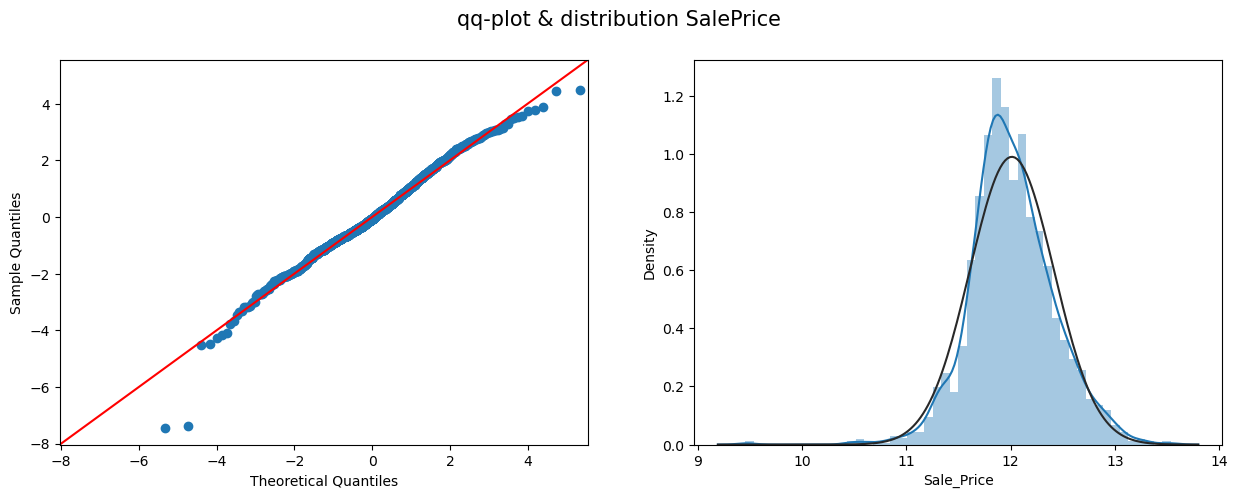

In [26]:
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
from scipy.stats import norm

target_log = np.log(y_train)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("qq-plot & distribution SalePrice ", fontsize=15)

sm.qqplot(target_log, stats.t, distargs=(4,), fit=True, line="45", ax=ax[0])
sns.distplot(target_log, kde=True, hist=True, fit=norm, ax=ax[1])
plt.show()

y_train = target_log
y_test = np.log(y_test)


### Sostituzione delle parole in valori

### One Hot-Encoding
Tramite questo algoritmo trasformiamo i valori stringa in colonne distinte del database e metto 0 o 1


In [27]:
#Analizzando la frequenza di determinati valori posso assumere per esempio che 'I_all' e 'A_agr' essendo in minor misura
#posso inserirli in una colonna 'Other' 
X_train["MS_Zoning"].value_counts() 

Residential_Low_Density         1579
Residential_Medium_Density       338
Floating_Village_Residential      89
Residential_High_Density          23
C_all                             19
A_agr                              2
I_all                              1
Name: MS_Zoning, dtype: int64

In [28]:
X_train.loc[(X_train["MS_Zoning"]== 'C_all'),"MS_Zoning"] = "Other"
X_train.loc[(X_train["MS_Zoning"]== 'I_all'),"MS_Zoning"] = "Other"
X_train.loc[(X_train["MS_Zoning"]== 'A_agr'),"MS_Zoning"] = "Other"
X_train["MS_Zoning"].value_counts()

X_test.loc[(X_test["MS_Zoning"]== 'C_all'),"MS_Zoning"] = "Other"
X_test.loc[(X_test["MS_Zoning"]== 'I_all'),"MS_Zoning"] = "Other"
X_test.loc[(X_test["MS_Zoning"]== 'A_agr'),"MS_Zoning"] = "Other"

#Runnalo e divertiti
plt.figure(figsize=(30, 400))
plt.title('Full view')
col= X_train.columns
l=int(len(col))
j = 1
for i in col:  
    ax=plt.subplot(l, 1,j)
    j += 1
    plt.scatter(X_train[i],y_train)
    ax.set_title(i)

In [29]:
from sklearn.preprocessing import OneHotEncoder
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))


ohe = OneHotEncoder(
    categories='auto', 
    drop=None, 
    sparse_output=False,
    handle_unknown='ignore',
    min_frequency = 0.25, #imposto una frequenza dei dati per creare Other 
    max_categories = 5 # imposto un numero di categorie massime per non avere 20000 colonne
)



object_col = X_train.select_dtypes(include=['object']).columns.tolist()


ohe.fit(X_train[object_col])
enc_df_train = pd.DataFrame(ohe.transform(X_train[object_col]))
enc_df_test = pd.DataFrame(ohe.transform(X_test[object_col]))
    
enc_df_train.columns=ohe.get_feature_names_out()
enc_df_test.columns=ohe.get_feature_names_out()





X_train = pd.concat([X_train.reset_index(drop=True),enc_df_train.reset_index(drop=True)],axis=1)
X_test = pd.concat([X_test.reset_index(drop=True),enc_df_test.reset_index(drop=True)],axis=1)

for a in object_col:
    X_test = X_test.drop(columns=a)
    X_train = X_train.drop(columns=a)




#Controllo la presenza di NaN value
for x in X_train.columns:
    if X_train[x].isnull().values.any()==True:
        print(x)
        print(X_train[x])

for x in X_test.columns:
    if X_test[x].isnull().values.any()==True:
        print(x)
        print(X_test[x])

The nltk version is 3.7.
The scikit-learn version is 1.2.2.


In [30]:
#Controllo dimensioni
X_train.shape, X_test.shape

((2051, 140), (879, 140))

# Random Forest


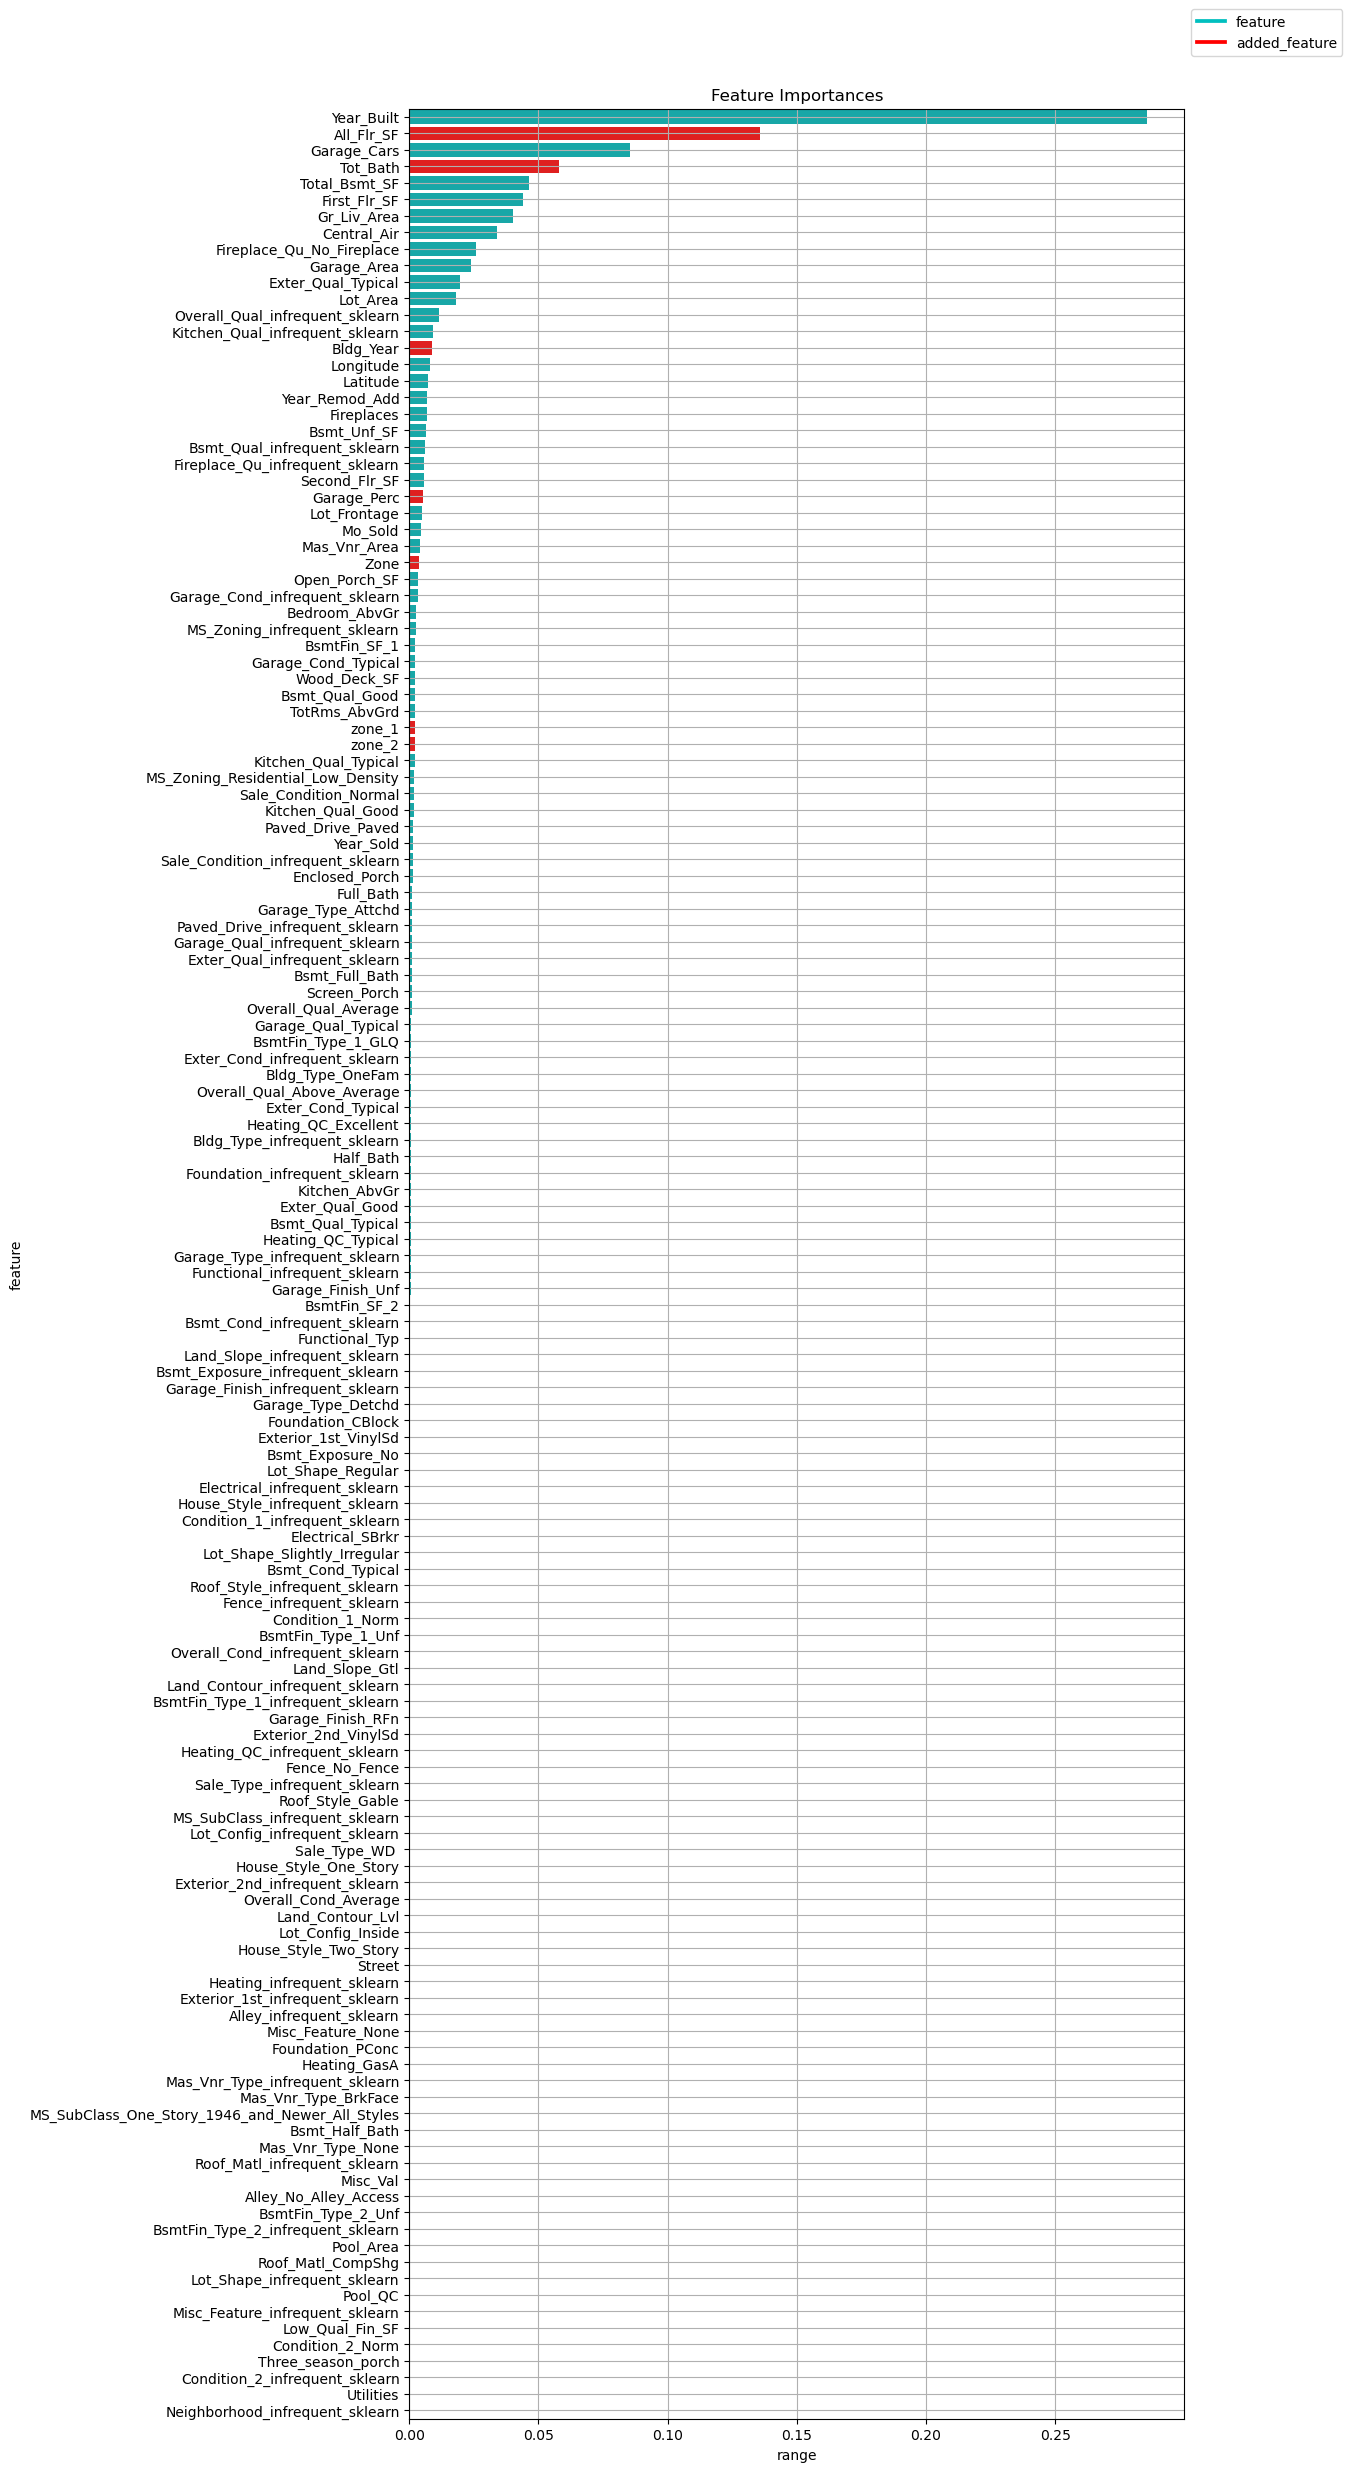

In [31]:
from sklearn.ensemble import RandomForestRegressor

X = X_train
y = y_train
rf = RandomForestRegressor(n_estimators=401,criterion = 'friedman_mse',n_jobs=-1)
rf.fit(X,y)
d= {}
for i in range(0,X.shape[1]):
    d[X.columns[i]] = rf.feature_importances_[i]
    #print(f'{X_trainF.columns[i]} \n feature importance : {rf.feature_importances_[i]:5f} \n\n' )
fig, ax = plt.subplots(figsize=(10,30))
feature_importance= pd.DataFrame({"range": rf.feature_importances_,
                   "feature": X.columns })
zone_feature= ['Zone','zone_1','zone_2']
added_feature=['Bldg_Year', 'Tot_Bath', 'Garage_Perc', 'All_Flr_SF'] + zone_feature

ad_fet= pd.DataFrame(feature_importance.loc[feature_importance['feature'].isin(added_feature)])
feat_imp= pd.DataFrame(feature_importance.loc[~feature_importance['feature'].isin(added_feature)])
ax= sns.barplot(x='range',
            y=feat_imp['feature'], data=feat_imp,
            order=feature_importance.sort_values('range').feature, color='c')

ax = sns.barplot(x='range',
            y=ad_fet['feature'], data=ad_fet,
            order=feature_importance.sort_values('range').feature,color='r')
            
ax.set_title("Feature Importances")
plt.legend(labels=['feature', 'added_feature'],bbox_to_anchor=(1, 1.02))
leg = ax.get_legend()
leg.legend_handles[0].set_color('c')
leg.legend_handles[1].set_color('r')
ax.invert_yaxis() 
ax.grid()


In [32]:
#eleiminazioni delle feature "zone" aggiunte per il confronto
data_zone= feature_importance.loc[feature_importance['feature'].isin(zone_feature)]
zone_feature.remove(data_zone[data_zone['range']== data_zone.max()['range']]['feature'].values[0])
X_train= X_train.drop(columns=zone_feature )
X_test= X_test.drop(columns=zone_feature )
for key in zone_feature:
    del d[key]

In [33]:
def selecting_features(X_train, X_test):
    #short data
    X_train_short = pd.DataFrame(X_train)
    X_test_short = pd.DataFrame(X_test)
    from sklearn.feature_selection import SelectFromModel
    sel = SelectFromModel(RandomForestRegressor(n_estimators = 401 , criterion = 'friedman_mse',n_jobs=-1))
    sel.fit(X_train_short, y_train)
    selected_feat= X_train_short.columns[(sel.get_support())]

    columns= X_train_short.columns
    for value in columns:
        if value not in selected_feat:
            X_train_short = X_train_short.drop(columns=value)
            X_test_short = X_test_short.drop(columns=value)
    print(f'len short: {len(X_train_short.columns)}\n')
    X_train_short.to_csv('train-test/X_train_short.csv', index=False)
    X_test_short.to_csv('train-test/X_test_short.csv', index=False)

    #medium
    X_train_medium = pd.DataFrame(X_train)
    X_test_medium = pd.DataFrame(X_test)
    a= pd.DataFrame(sorted(d.items(), key=lambda x:x[1],reverse=True))
    for key, value in d.items():
        if value < a.quantile(.70, axis = 0)[1]:
            X_train_medium = X_train_medium.drop(columns=key)
            X_test_medium = X_test_medium.drop(columns=key)
    X_train_medium.to_csv('train-test/X_train_medium.csv', index=False)
    X_test_medium.to_csv('train-test/X_test_medium.csv', index=False)
    print(f'len medium: {len(X_train_medium.columns)}\n')

    #large
    X_train.to_csv('train-test/X_train_large.csv', index=False)
    X_test.to_csv('train-test/X_test_large.csv', index=False)
    print(f'len large: {len(X_train.columns)}')
    
    y_test.to_csv('train-test/y_test.csv', index=False)
    y_train.to_csv('train-test/y_train.csv', index=False)
    


In [34]:
selecting_features(X_train, X_test) 

len short: 16

len medium: 42

len large: 138


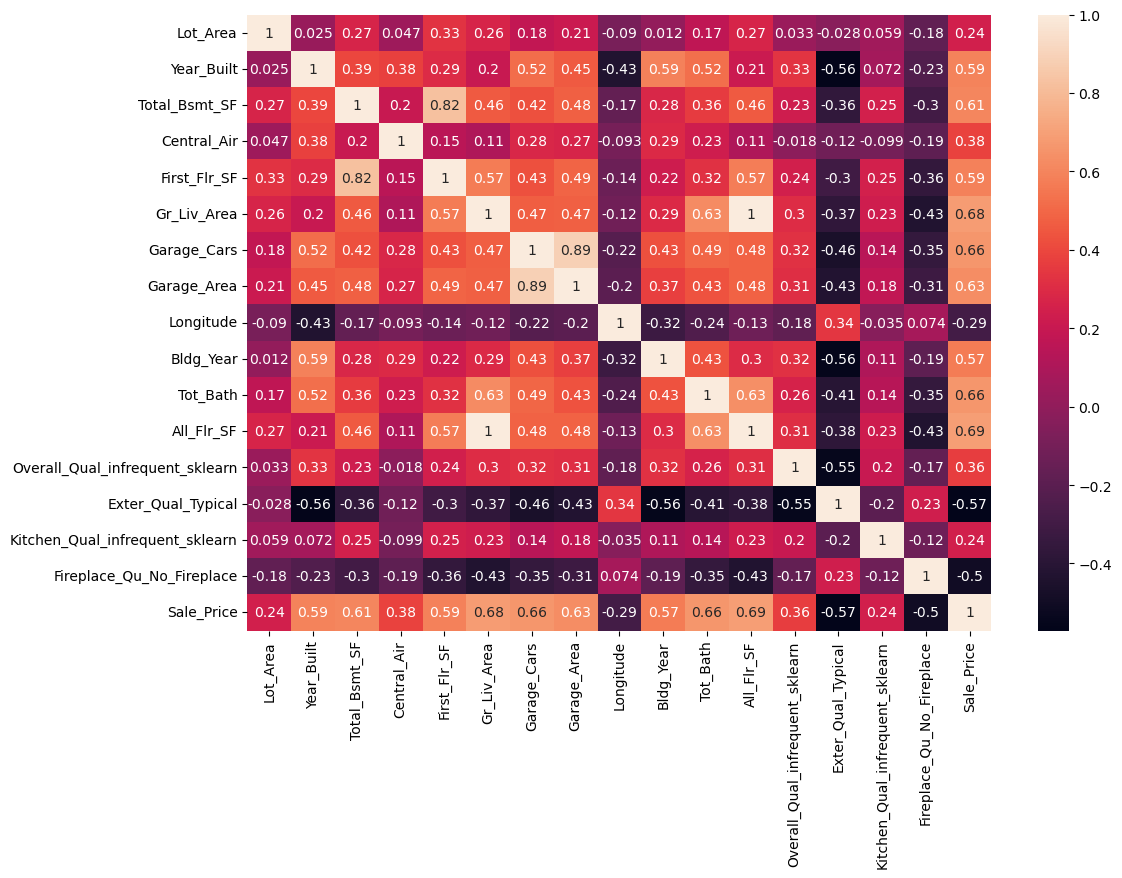

In [36]:
X_train= pd.read_csv("train-test/X_train_short.csv")
y_train= pd.read_csv("train-test/y_train.csv")
xy_train = pd.concat([X_train, y_train], axis=1)
corr = xy_train.corr()
plt.subplots(figsize=(12, 8))
sns.heatmap(corr, annot=True)
plt.show()